# ChannelTS
A `ChannelTS` object is a container for a single channel.  The data are stored in an `xarray.DataArray` and indexed by time according to the metadata provided.  Here we will make a simple `electric` channel and look at how to interogate it.

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS
from mt_metadata.timeseries import Electric, Run, Station

Here create some metadata, the keys are the `time_period.start` and the `sample_rate`. 

In [2]:
ex_metadata = Electric()
ex_metadata.time_period.start = "2020-01-01T00:00:00"
ex_metadata.sample_rate = 8.0
ex_metadata.component = "ex"
ex_metadata.dipole_length = 100.
ex_metadata.units = "millivolts"

Create `Station` and `Run` metadata

In [3]:
station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

Create "realistic" data 

In [4]:
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

In [5]:
ex = ChannelTS(channel_type="electric",
              data=data,
              channel_metadata=ex_metadata,
              run_metadata=run_metadata,
              station_metadata=station_metadata)

In [6]:
ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:08:31.875000+00:00
	N Samples:    4096

## Get a slice of the data
Here we will provide a start time of the slice and the number of samples that we want the slice to be


In [7]:
ex_slice = ex.get_slice("2020-01-01T00:00:00", n_samples=256)

In [8]:
ex_slice

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:00:31.875000+00:00
	N Samples:    256

## Plot the data
This is a work in progress, but this can be done through the `xarray` container.

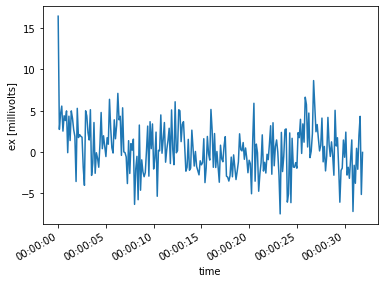

In [9]:
ex_slice.plot()

## Convert to an `xarray`
We can convert the `ChannelTS` object to an `xarray.DataArray` which could be easier to use.

In [10]:
ex_xarray = ex.to_xarray()

In [11]:
ex_xarray

<xarray.DataArray 'ex' (time: 4096)>
array([16.43704101,  2.7440483 ,  4.62460915, ..., -3.61015321,
       -0.73752295,  1.85945637])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-01T00:08:31.875000
Attributes:
    channel_number:             0
    component:                  ex
    data_quality.rating.value:  0
    dipole_length:              100.0
    filter.applied:             [False]
    filter.name:                []
    measurement_azimuth:        0.0
    measurement_tilt:           0.0
    negative.elevation:         0.0
    negative.id:                None
    negative.latitude:          0.0
    negative.longitude:         0.0
    negative.manufacturer:      None
    negative.type:              None
    positive.elevation:         0.0
    positive.id:                None
    positive.latitude:          0.0
    positive.longitude:         0.0
    positive.manufacturer:      None
    positive.type:              None
    sample_rate:                8.0
    time_period.end:            2020-01-01T00:08:31.875000+00:00
    time_period.start:          2020-01-01T00:00:00+00:00
    type:                       electric
    units:                      millivolts
    station.id:                 mt001
    run.id:                     001

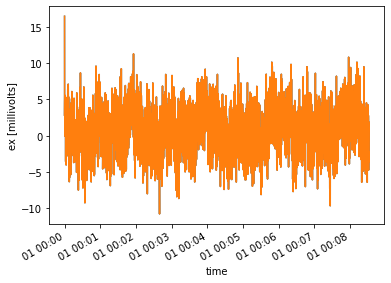

In [12]:
ex.plot()
ex_xarray.plot()

## Convert to an `Obspy.Trace` object
The `ChannelTS` object can be converted to an `obspy.Trace` object.  This can be useful when dealing with data received from a mainly seismic archive like IRIS.  This can also be useful for using some tools provided by [Obspy](https://docs.obspy.org/).  

**Note** there is a loss of information when doing this because an `obspy.Trace` is based on miniSEED data formats which has minimal metadata.  

In [13]:
ex.station_metadata.fdsn.id = "mt001"
ex_trace = ex.to_obspy_trace()

In [14]:
ex_trace

.mt001..MQN | 2020-01-01T00:00:00.000000Z - 2020-01-01T00:08:31.875000Z | 8.0 Hz, 4096 samples

## Convert from an `Obspy.Trace` object
We can reverse that and convert an `obspy.Trace` into a `ChannelTS`.  Again useful when dealing with seismic dominated archives.

In [15]:
ex_from_trace = ChannelTS()
ex_from_trace.from_obspy_trace(ex_trace)

In [16]:
ex_from_trace

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          sr8_001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:08:31.875000+00:00
	N Samples:    4096

In [17]:
ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:08:31.875000+00:00
	N Samples:    4096

On comparison you can see the loss of metadata information.  

## Calibrate 

Removing the instrument response to calibrate the data is an important step in processing the data.  A convenience function `ChannelTS.remove_instrument_response` is supplied just for this.  
Currently, it will calibrate the whole time series at once and therefore may be slow for large data sets.  

<div class="alert alert-block alert-success">
<b>See Also:</b> `Make Data From IRIS` examples for working examples.
</div>

In [18]:
help(ex.remove_instrument_response)

Help on method remove_instrument_response in module mth5.timeseries.channel_ts:

remove_instrument_response(**kwargs) method of mth5.timeseries.channel_ts.ChannelTS instance
    Remove instrument response from the given channel response filter
    
    The order of operations is important (if applied):
    
        1) detrend
        2) zero mean
        3) zero pad
        4) time window
        5) frequency window
        6) remove response
        7) undo time window
        8) bandpass
    
    **kwargs**
    
    :param plot: to plot the calibration process [ False | True ]
    :type plot: boolean, default True
    :param detrend: Remove linar trend of the time series
    :type detrend: boolean, default True
    :param zero_mean: Remove the mean of the time series
    :type zero_mean: boolean, default True
    :param zero_pad: pad the time series to the next power of 2 for efficiency
    :type zero_pad: boolean, default True
    :param t_window: Time domain windown name see `scipy

## XArray Accessor for Decimate and Filtering

A common practice when working with time series would be decimating or downsampling the data.  `xarray` has some builtins for resampling, however these do not apply a filter prior to downsampling and has alias issues.  We have added some utilities for decimation and filtering following the package [xr-scipy](https://github.com/fujiisoup/xr-scipy/tree/master/xrscipy).  When MTH5 is initiated a `sps_filters` accessor to `xarray.DataArray` and `xarray.Dataset` which includes some filtering methods as well as decimation and resampling.  Therefore for access to these methods use `DataArray.sps_filters.decimate` or `Dataset.sps_filters.decimate`.  

Methods include 

| Name | Function |
|------|----------|
| `lowpass` | low pass filter the data|
| `highpass` | high pass filter the data |
| `bandpass` | band pass filter the data |
| `bandstop` | filter out frequencies using a band stop (notch filter) |
| `decimate` | simulates `scipy.signal.decimate` method by filtering data first then decimating.  Can be inaccurate around the edges of the time series because it assumes periodic signal. |
| `resample_poly` | uses `scipy.signal.resample_poly` method for down sampling, more accurate and usually faster for real signals (default for resampling) |
| `detrend` | uses `scipy.signal.detrend` with keyword `type` to remove trends in the data |  

<div class="alert alert-block alert-info">
<b>Note:</b> In future versions of MTH5 filters will be added to ChannelTS.
</div>

### Compare Downsampling methods

#### `Decimate`

Here we will decimate to a new sample rate of 1 sample per second.  

In [19]:
decimated_ex = ex.decimate(1)

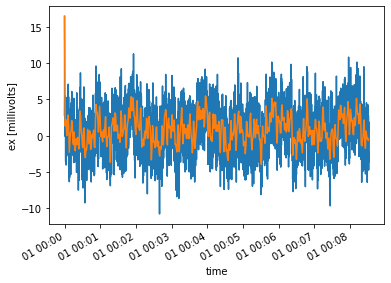

In [20]:
ex.plot()
decimated_ex.plot()

#### `resample_poly`

`resample_poly` is more accurate for real signals because there is no innate assumption of periodicity.  As you can see in the `decimate` case there are edge effects.  Have a look at the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html) for more information. In the plot below, you'll notice no edge effects and similar numbers as `decimate`. 

<div class="alert alert-block alert-info">
<b>Note:</b> Strongly suggest using `ChannelTS.resample_poly` for downsampling data.
</div>

In [28]:
resample_poly_ex = ex.resample_poly(1)

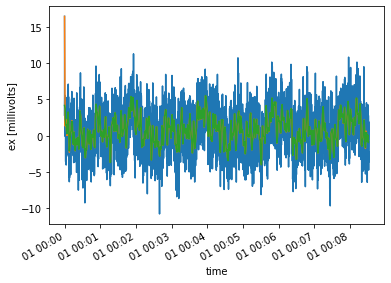

In [29]:
ex.plot()
decimated_ex.plot()
resample_poly_ex.plot()

## Merge Channels

A common step in working with time series would be to combine different segments of collected for the same channel. If the sample rates are the same you can use `channel_01 + channel_02`.  This should also work if the sample rates are not the same, though you should use `ChannelTS.merge` if the sample rates are not the same. The channels combined must have the same component.  There are two builtin methods to combine channels those are `+` and `merge()`.  

  1. `added_channel = cnahhel_01 + channel_02`
  2. `merged_channel = channel_01.merge(channel_02)` 
  
Both methods use `xarray.combine_by_coords([ch1, rch2], combine_attrs='override'`.  The `combine_by_coords` method simply concatenates along similar dimensions and cares nothing of a monotonix dimension variable.  Therefore, `xarray.DataArray.reindex` is used to create a monotonically increasing time series.  Any gaps are filled interpolated using a 1-D interpolation.  The default method is `slinear` which is probably the most useful for processing time series.  If you want more control over the interpolation method use `ChannelTS.merge([ch1, ch2, ...], gap_method=interpolation_method`.  For more information on interpolation methods see [Scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html). Similarly if you want more control on how the datasets are merged use [xarray tools](https://docs.xarray.dev/en/stable/user-guide/combining.html).  

### Add Channels

Adding channels together does 2 at a time so if you are adding multiple channels together `channel_01 + channel_02 + channel_03 ...` its better to use `merge`.  Also if you want more control on how the channels are merged and how time gaps are interpolated use `merge`.

In [21]:
ex2 = ex.copy()
ex2.start = "2020-01-01T00:08:45"

In [22]:
added_channel = ex + ex2

In [23]:
added_channel

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:17:16.875000+00:00
	N Samples:    8296

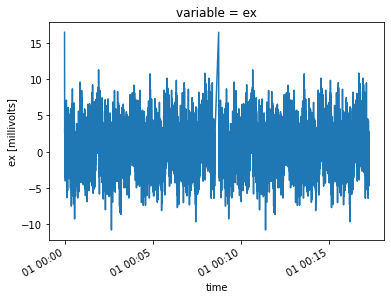

In [24]:
added_channel.plot()

### Merge Channels And Resample

If channels have different sample rates or you want to combine channels and resample to a lower sample rate, use the keyword argument `new_sample_rate`.

In [25]:
merged_channel = ex.merge(ex2, new_sample_rate=1)

In [26]:
merged_channel

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:17:16+00:00
	N Samples:    1037

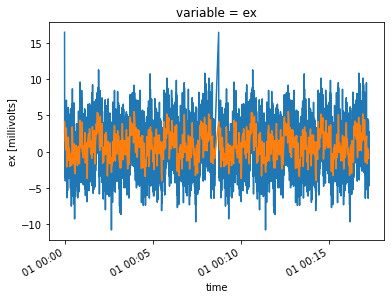

In [27]:
added_channel.plot()
merged_channel.plot()